In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import json
import urllib.request
import requests
import time
import os

from tqdm import tqdm
from sklearn.cluster import DBSCAN

#### Premier dataset

In [2]:
url = 'https://projet-incendie.s3.eu-west-3.amazonaws.com/Incendies_2006_2024.csv'

df = pd.read_csv(url, sep=';', encoding='utf-8', skiprows=3)
pd.set_option('display.max_columns', None)

print(df.head(10))
print(df.shape)

   2014  2546   2A  2A139                  Lecci  2014-01-09 16:14:00     10  \
0  2014     6   65  65173                Esterre  2014-01-10 20:04:00  10000   
1  2014  8243   2B  2B058                 Canari  2014-01-11 14:00:00    100   
2  2014     7   65  65233                 Jarret  2014-01-12 16:41:00    200   
3  2014  1997   30  30051  Branoux-les-Taillades  2014-01-13 19:24:00   2500   
4  2014  6439   66  66196                 Sorède  2014-01-17 16:40:00  10000   
5  2014  6002   2B  2B242         Poggio-Mezzana  2014-01-18 14:57:00   3000   
6  2014    56  974  97421                Salazie  2014-01-21 14:08:00   3000   
7  2014     1  974  97412           Saint-Joseph  2014-01-21 17:27:00  10000   
8  2014    57  974  97410           Saint-Benoît  2014-01-21 18:28:00   2000   
9  2014  1986   06  06122          Saint-Jeannet  2014-01-26 12:21:00   3000   

   Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  Unnamed: 12  \
0     10000.0         NaN         0.0  

C:\Users\joelt\AppData\Local\Temp\ipykernel_2132\1362979716.py:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=';', encoding='utf-8', skiprows=3)


In [3]:
url_ville = 'https://projet-incendie.s3.eu-west-3.amazonaws.com/coordonnees_villes.csv'
coords=pd.read_csv(url_ville, sep=',', encoding='utf-8')
coords.head(10)

ville   latitude  longitude
0      Salses-le-Château  42.833380   2.918180
1              Lantosque  43.973468   7.312593
2                  Lecci  41.679373   9.317798
3                Esterre  42.874901   0.006078
4                 Canari  42.845933   9.331333
5                 Jarret  43.082300  -0.014354
6  Branoux-les-Taillades  44.219600   3.991240
7                 Sorède  42.530402   2.956454
8         Poggio-Mezzana  42.397680   9.493930
9                Salazie -21.024383  55.543545

In [4]:
coords.rename(columns={"ville": "Nom de la commune"}, inplace=True)
coords.head(5)

Nom de la commune   latitude  longitude
0  Salses-le-Château  42.833380   2.918180
1          Lantosque  43.973468   7.312593
2              Lecci  41.679373   9.317798
3            Esterre  42.874901   0.006078
4             Canari  42.845933   9.331333

In [5]:
coords=coords.dropna(subset=['latitude', 'longitude'])
coords.isna().sum()

Nom de la commune    0
latitude             0
longitude            0
dtype: int64

### Vérification visuelle de la pertinence des coordonnées GPS

In [6]:
fig = px.scatter_mapbox(
    coords, 
    lat="latitude", 
    lon="longitude", 
    hover_name="Nom de la commune",
    height=1000,
    title='Visu de tous les incendies entre 2006 et 2024',
    zoom=5,
    mapbox_style="carto-positron")
fig.show()

#### Visu des causes d'incendie

In [7]:
df_merge=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/historique_incendies_avec_coordonnees.csv', sep=';', encoding='utf-8')

In [8]:
df_merge.columns

Index(['Département', 'Code INSEE', 'Nom de la commune', 'latitude',
       'longitude', 'Date', 'Surface parcourue (m2)', 'Surface forêt (m2)',
       'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Type de peuplement', 'Nature', 'Feux'],
      dtype='object')

In [9]:
print(df_merge['Nature'].value_counts())

Nature
Malveillance                  8389
Involontaire (particulier)    6956
Involontaire (travaux)        4285
Accidentelle                  3342
Naturelle                     2780
Name: count, dtype: int64


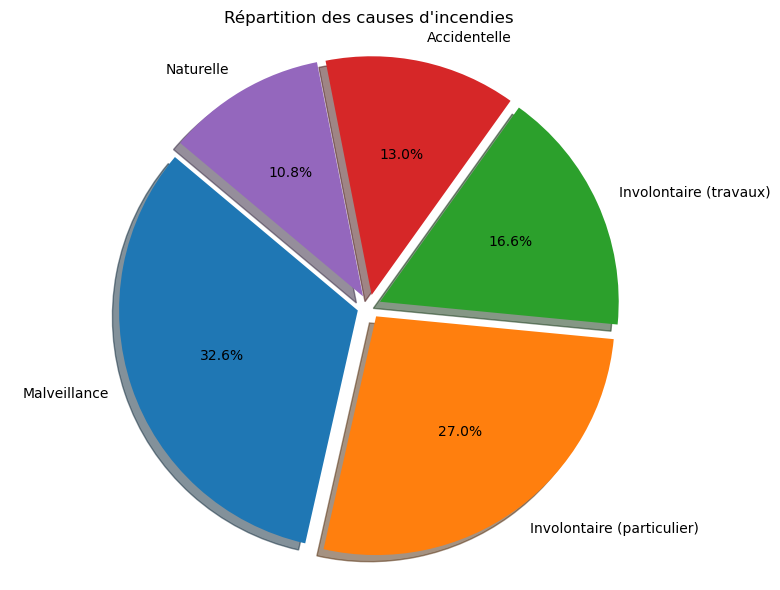

In [10]:
causes = df_merge['Nature'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(causes.values, labels=causes.index,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05]*len(causes))

plt.title("Répartition des causes d'incendies")
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Test de cluster avec DBScan

In [ ]:
commune_counts = df_merge.groupby(['Nom de la commune', 'latitude', 'longitude']).size().reset_index(name='frequence')

df_expanded = commune_counts.loc[commune_counts.index.repeat(commune_counts['frequence'])].reset_index(drop=True)

X = df_expanded[['latitude', 'longitude']]

In [12]:
coords_rad = np.radians(df_expanded[['latitude', 'longitude']])
kms_per_radian = 6371.0088
eps_km = 5
eps = eps_km / kms_per_radian
db = DBSCAN(eps=eps, min_samples=20, metric='haversine').fit(coords_rad)
df_expanded['cluster'] = db.labels_
clusters = df_expanded['cluster'].unique()
print(clusters)

[ -1   0   1   2   3   4   5  94  34  37   6   7   8   9  10  11  12  29
  13  14  15  16  17  18  57  19  20  21 287  22  23  24 182 128  25  26
  27 173  78  70  28 353  30  31  32 110  33  35  46  36  38 177  39  40
  41  42  75  43  44 260  45  47  48  49  50  51 151  52  53 286  54  55
 359  56  58  66  59  60  61  62  63  64  65  67  68  69  71  72  73  74
  76  77 197 164 332  79  80  95  81  82 294  83  84 314 250  85  86  87
  88  89 198  90  91  92  93 311 139  96 113  97  98  99 115 100 101 102
 103 183 104 105 106 108 334 107 169 109 111 112 114 116 117 118 119 120
 121 122 123 124 125 126 127 259 129 130 131 132 290 133 134 135 136 137
 138 208 140 141 142 155 143 144 145 146 147 274 313 187 148 149 150 285
 328 152 153 154 252 156 157 158 304 200 275 210 159 160 161 162 163 299
 171 165 166 167 168 261 170 172 226 192 174 175 176 178 185 179 180 181
 320 184 205 186 188 189 190 191 193 194 195 196 207 199 201 202 203 204
 206 209 291 211 212 213 342 214 215 216 217 218 21

In [13]:
fig = px.scatter_mapbox(

        df_expanded[df_expanded.cluster != -1],
        lat="latitude",
        lon="longitude",
        color="cluster",
        hover_name="Nom de la commune",
        title="Clusters d'incendies en France (2006-2024)",
        zoom=5.2,
        height = 1000,        mapbox_style="carto-positron"
)

fig.show()

#### Visu de l'évolution des feux

In [ ]:

df_temp = df_merge.copy()
df_temp['Date'] = pd.to_datetime(df_temp['Date'])
df_temp['mois'] = df_temp['Date'].dt.month
df_temp['année'] = df_temp['Date'].dt.year

mois_abbr = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin',
             'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Dec']
df_temp['mois_nom'] = df_temp['mois'].apply(lambda x: mois_abbr[x - 1])

df_temp['mois_nom'] = pd.Categorical(df_temp['mois_nom'], categories=mois_abbr, ordered=True)

df_grouped = df_temp.groupby(['année', 'mois_nom']).size().reset_index(name='nombre_feux')

df_moyenne = df_grouped.groupby('mois_nom')['nombre_feux'].mean().reset_index()
df_moyenne.rename(columns={'nombre_feux': 'moyenne_feux'}, inplace=True)

fig = px.bar(
    df_moyenne,
    x='mois_nom',
    y='moyenne_feux',
    title='Moyenne mensuelle des incendies sur toutes les années',
    height=600,
    width=1000
)

fig.update_layout(
    xaxis_title='Mois',
    yaxis_title='Moyenne du nombre de feux',
    xaxis_tickangle=-45
)

fig.show()


C:\Users\joelt\AppData\Local\Temp\ipykernel_2132\3610051132.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\joelt\AppData\Local\Temp\ipykernel_2132\3610051132.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [15]:

df_temp = df_merge.copy()

df_temp['Date'] = pd.to_datetime(df_temp['Date'])
df_temp['année'] = df_temp['Date'].dt.year

df_grouped = df_temp.groupby('année').size().reset_index(name='nombre_feux')

fig = px.bar(
    df_grouped,
    x='année',
    y='nombre_feux',
    title='Nombre total d’incendies par année',
    height=600,
    width=1200,
    text='nombre_feux'
)

fig.update_xaxes(
    tickmode='linear',
    dtick=1
)

fig.update_layout(
    xaxis_title='Année',
    yaxis_title='Nombre de feux',
    xaxis_tickangle=0
)

fig.show()


In [16]:
df_merge.head()

Département Code INSEE  Nom de la commune   latitude  longitude  \
0          66      66190  Salses-le-Château  42.833380   2.918180   
1          06      06074          Lantosque  43.973468   7.312593   
2          2A      2A139              Lecci  41.679373   9.317798   
3          65      65173            Esterre  42.874901   0.006078   
4          2B      2B058             Canari  42.845933   9.331333   

                  Date  Surface parcourue (m2)  Surface forêt (m2)  \
0  2014-01-02 14:56:00                   10000                 NaN   
1  2014-01-07 13:50:00                   48400                 NaN   
2  2014-01-09 16:14:00                      10                 NaN   
3  2014-01-10 20:04:00                   10000             10000.0   
4  2014-01-11 14:00:00                     100                 NaN   

   Surface maquis garrigues (m2)  Autres surfaces naturelles hors forêt (m2)  \
0                        10000.0                                         NaN   
1                        48400.0                                         NaN   
2                            NaN                                         NaN   
3                            NaN                                         0.0   
4                            NaN                                         NaN   

   Surfaces agricoles (m2)  Autres surfaces (m2)  \
0                      NaN                   NaN   
1                      NaN                   NaN   
2                      NaN                   NaN   
3                      NaN                   NaN   
4                      NaN                   NaN   

   Surface autres terres boisées (m2)  Surfaces non boisées naturelles (m2)  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                                 NaN                                   NaN   
3                                 0.0                                   0.0   
4                                 NaN                                   NaN   

   Surfaces non boisées artificialisées (m2)  Surfaces non boisées (m2)  \
0                                        NaN                        NaN   
1                                        NaN                        NaN   
2                                        NaN                        NaN   
3                                        0.0                        0.0   
4                                        NaN                        NaN   

   Type de peuplement                      Nature  Feux  
0                 1.0  Involontaire (particulier)     1  
1                 1.0                         NaN     1  
2                 NaN                         NaN     1  
3                 NaN                         NaN     1  
4                 NaN                         NaN     1

In [17]:
df_temp = df_merge.copy()

df_grouped = df_temp.groupby('Département').size().reset_index(name='nombre_feux')

df_top10 = df_grouped.sort_values(by='nombre_feux', ascending=False).head(10)

fig = px.bar(
    df_top10,
    x='Département',
    y='nombre_feux',
    title='Les 10 départements avec le plus d’incendies',
    height=600,
    width=1000,
    text='nombre_feux'
)

fig.update_layout(
    xaxis_title='Département',
    yaxis_title='Nombre de feux',
    xaxis_tickangle=-45
)

fig.show()


In [ ]:
df_temp = df_merge.copy()

df_temp['Département'] = df_temp['Département'].astype(str).str.zfill(2)
df_grouped = df_temp.groupby('Département').size().reset_index(name='nombre_feux')

url_geojson = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson'
with urllib.request.urlopen(url_geojson) as response:
    departements_geojson = json.load(response)

# Carte choroplèthe
fig = px.choropleth(
    df_grouped,
    geojson=departements_geojson,
    locations='Département',
    featureidkey='properties.code',
    color='nombre_feux',
    color_continuous_scale='OrRd',
    title='Total des feux par département 2006-2024',
    labels={'nombre_feux': 'Feux'},
)

fig.update_geos(
    visible=False,
    lataxis_range=[41, 52],    # ↑ La Corse jusqu'au nord de la métropole
    lonaxis_range=[-5.5, 10],  # ←→ Limites ouest/est correctes
)

fig.update_layout(
    width=1000,
    height=700,  # Légèrement plus haut
    coloraxis_colorbar=dict(
        title="Feux",
        thickness=15,
        len=0.4,
        y=0.5
    ),
    margin=dict(l=0, r=20, t=40, b=0)
)


In [19]:
df_temp = df_merge.copy()

df_temp['Département'] = df_temp['Département'].replace({'2A': '2A/2B', '2B': '2A/2B'})

df_grouped = df_temp.groupby('Département')['Surface parcourue (m2)'].sum().reset_index(name='Surface parcourue (m2)')

df_top10 = df_grouped.sort_values(by='Surface parcourue (m2)', ascending=False).head(10)

fig = px.bar(
    df_top10,
    x='Département',
    y='Surface parcourue (m2)',
    title='Les 10 Départements avec la plus grande surface parcourue',
    height=600,
    width=1000,
  
)

fig.update_layout(
    xaxis_title='Département',
    yaxis_title='Surface parcourue (m2)',
    xaxis_tickangle=-45
)

fig.show()



In [20]:
# # Requête Overpass : casernes de pompiers ("fire_station") en Corse
# overpass_url = "https://overpass-api.de/api/interpreter"
# overpass_query = """
# [out:json][timeout:25];
# area["name"="Corse"][admin_level=4]->.corse;
# (
#   node["amenity"="fire_station"](area.corse);
#   way["amenity"="fire_station"](area.corse);
#   relation["amenity"="fire_station"](area.corse);
# );
# out center;
# """

# # Exécution de la requête
# response = requests.post(overpass_url, data={'data': overpass_query})
# data = response.json()

# # Extraction des éléments
# elements = data['elements']
# records = []

# for el in elements:
#     tags = el.get('tags', {})
    
#     # Utiliser les coordonnées centrales pour nodes, ways et relations
#     lat = el.get('lat') or el.get('center', {}).get('lat')
#     lon = el.get('lon') or el.get('center', {}).get('lon')
    
#     records.append({
#         'nom': tags.get('name', 'Inconnu'),
#         'latitude': lat,
#         'longitude': lon,
#         'type': el['type'],
#         'id': el['id']
#     })

# # Conversion en DataFrame
# df_casernes = pd.DataFrame(records)

# # Affichage
# print(df_casernes.head())


In [ ]:
df_casernes.to_csv('casernes_corses.csv')

#### Fusion des datasets

In [ ]:
citernes=pd.read_csv('citernes-incendies.csv', sep=',', encoding='utf8')
citernes.head()

Unnamed: 0   Description                    Lieu   latitude  longitude
0           0  Citerne DFCI      Giannuccio village  41.566411   9.037712
1           1  Citerne DFCI      Giannuccio Banditi  41.552074   9.024082
2           2  Citerne DFCI  Monacia  Sapera longa   41.534353   9.017717
3           3  Citerne DFCI     Monacia   Budiccia   41.499586   9.002322
4           4  Citerne DFCI        Monacia Mariolo   41.496836   8.961988

In [ ]:
bornes=pd.read_csv('bornes-incendies.csv', sep=',', encoding='utf8')
bornes.head()

Unnamed: 0          Description                     Lieu   latitude  \
0           0  Borne incendie DFCI         Monacia   Eglise  41.513683   
1           1  Borne incendie DFCI          Monacia   Poste  41.513618   
2           2  Borne incendie DFCI       Monacia  Rotondolo  41.512498   
3           3  Borne incendie DFCI  Monacia   Reservoir eau  41.514803   
4           4  Borne incendie DFCI           Monacia RN 196  41.500244   

   longitude  
0   9.011877  
1   9.012612  
2   9.013768  
3   9.015002  
4   9.004895

In [ ]:
bornes_citernes = pd.concat([bornes, citernes], ignore_index=True, sort=False)
bornes_citernes


Unnamed: 0          Description                         Lieu   latitude  \
0            0  Borne incendie DFCI             Monacia   Eglise  41.513683   
1            1  Borne incendie DFCI              Monacia   Poste  41.513618   
2            2  Borne incendie DFCI           Monacia  Rotondolo  41.512498   
3            3  Borne incendie DFCI      Monacia   Reservoir eau  41.514803   
4            4  Borne incendie DFCI               Monacia RN 196  41.500244   
5            5  Borne incendie DFCI        Embranchement Monacia  41.502493   
6            6  Borne incendie DFCI          Monacia -Caniscione  41.502493   
7            7  Borne incendie DFCI  Monacia Hameau de Gianuccio  41.512034   
8            8  Borne incendie DFCI               Monacia Teggia  41.514390   
9            9  Borne incendie DFCI            Monacia Frisella   41.512034   
10           0         Citerne DFCI           Giannuccio village  41.566411   
11           1         Citerne DFCI           Giannuccio Banditi  41.552074   
12           2         Citerne DFCI       Monacia  Sapera longa   41.534353   
13           3         Citerne DFCI          Monacia   Budiccia   41.499586   
14           4         Citerne DFCI             Monacia Mariolo   41.496836   
15           5              Citerne                    Fornello   41.496836   

    longitude  
0    9.011877  
1    9.012612  
2    9.013768  
3    9.015002  
4    9.004895  
5   41.502493  
6    9.029979  
7    9.010898  
8    9.014518  
9    9.010898  
10   9.037712  
11   9.024082  
12   9.017717  
13   9.002322  
14   8.961988  
15   8.961988

In [ ]:
bornes_citernes.rename(columns={'Description': 'nom'}, inplace=True)
bornes_citernes



Unnamed: 0                  nom                         Lieu   latitude  \
0            0  Borne incendie DFCI             Monacia   Eglise  41.513683   
1            1  Borne incendie DFCI              Monacia   Poste  41.513618   
2            2  Borne incendie DFCI           Monacia  Rotondolo  41.512498   
3            3  Borne incendie DFCI      Monacia   Reservoir eau  41.514803   
4            4  Borne incendie DFCI               Monacia RN 196  41.500244   
5            5  Borne incendie DFCI        Embranchement Monacia  41.502493   
6            6  Borne incendie DFCI          Monacia -Caniscione  41.502493   
7            7  Borne incendie DFCI  Monacia Hameau de Gianuccio  41.512034   
8            8  Borne incendie DFCI               Monacia Teggia  41.514390   
9            9  Borne incendie DFCI            Monacia Frisella   41.512034   
10           0         Citerne DFCI           Giannuccio village  41.566411   
11           1         Citerne DFCI           Giannuccio Banditi  41.552074   
12           2         Citerne DFCI       Monacia  Sapera longa   41.534353   
13           3         Citerne DFCI          Monacia   Budiccia   41.499586   
14           4         Citerne DFCI             Monacia Mariolo   41.496836   
15           5              Citerne                    Fornello   41.496836   

    longitude  
0    9.011877  
1    9.012612  
2    9.013768  
3    9.015002  
4    9.004895  
5   41.502493  
6    9.029979  
7    9.010898  
8    9.014518  
9    9.010898  
10   9.037712  
11   9.024082  
12   9.017717  
13   9.002322  
14   8.961988  
15   8.961988

In [26]:
df_casernes=pd.read_csv('https://projet-incendie.s3.eu-west-3.amazonaws.com/casernes_corses.csv', sep=',', encoding='utf8')
df_casernes.head()

Unnamed: 0.1  Unnamed: 0                                         nom  \
0             0           0  Centre d'incendie et de secours de Ghisoni   
1             1           1     Centre d'incendie et de secours d'Ocana   
2             2           2                    Base forestière d'Azzana   
3             3           3                       Base forestière d'Ota   
4             4           4                  Base forestière de Petreto   

    latitude  longitude  type            id Lieu  \
0  42.103294   9.212974  node  3.231991e+09  NaN   
1  41.963339   8.945611  node  7.948177e+09  NaN   
2  42.123937   8.944282  node  7.948201e+09  NaN   
3  42.263666   8.708481  node  7.948221e+09  NaN   
4  41.785613   8.979385  node  7.948408e+09  NaN   

                         categorie  
0  Centre d'incendie et de secours  
1  Centre d'incendie et de secours  
2                  Base forestière  
3                  Base forestière  
4                  Base forestière

In [27]:
pd.set_option('display.max_rows', None)
df_casernes = pd.concat([df_casernes, bornes_citernes], ignore_index=True, sort=False)
df_casernes


Unnamed: 0.1  Unnamed: 0  \
0            0.0           0   
1            1.0           1   
2            2.0           2   
3            3.0           3   
4            4.0           4   
5            5.0           5   
6            6.0           6   
7            7.0           7   
8            8.0           8   
9            9.0           9   
10          10.0          10   
11          11.0          11   
12          12.0          12   
13          13.0          13   
14          14.0          14   
15          15.0          15   
16          16.0          16   
17          17.0          17   
18          18.0          18   
19          19.0          19   
20          20.0          20   
21          21.0          21   
22          22.0          22   
23          23.0          23   
24          24.0          24   
25          25.0          25   
26          26.0          26   
27          27.0          27   
28          28.0          28   
29          29.0          29   
30          30.0          30   
31          31.0          31   
32          32.0          32   
33          33.0          33   
34          34.0          34   
35          35.0          35   
36          36.0          36   
37          37.0          37   
38          38.0          38   
39          39.0          39   
40          40.0          40   
41          41.0          41   
42          42.0          42   
43          43.0          43   
44          44.0          44   
45          45.0          45   
46          46.0          46   
47          47.0          47   
48          48.0          48   
49          49.0          49   
50          50.0          50   
51          51.0          51   
52          52.0          52   
53          53.0           0   
54          54.0           1   
55          55.0           2   
56          56.0           3   
57          57.0           4   
58          58.0           5   
59          59.0           6   
60          60.0           7   
61          61.0           8   
62          62.0           9   
63          63.0           0   
64          64.0           1   
65          65.0           2   
66          66.0           3   
67          67.0           4   
68          68.0           5   
69           NaN           0   
70           NaN           1   
71           NaN           2   
72           NaN           3   
73           NaN           4   
74           NaN           5   
75           NaN           6   
76           NaN           7   
77           NaN           8   
78           NaN           9   
79           NaN           0   
80           NaN           1   
81           NaN           2   
82           NaN           3   
83           NaN           4   
84           NaN           5   

                                                  nom   latitude  longitude  \
0          Centre d'incendie et de secours de Ghisoni  42.103294   9.212974   
1             Centre d'incendie et de secours d'Ocana  41.963339   8.945611   
2                            Base forestière d'Azzana  42.123937   8.944282   
3                               Base forestière d'Ota  42.263666   8.708481   
4                          Base forestière de Petreto  41.785613   8.979385   
5                          Base forestière de Sartène  41.628951   8.955765   
6                            Base forestière de Conca  41.692821   9.336244   
7   Centre de Première Intervention Intégrés de Be...  42.582409   9.019755   
8                                               SSLIA  41.921104   8.795186   
9                             Base forestière de Vico  42.162126   8.790158   
10            Centre d'incendie et de secours de Vico  42.165636   8.797316   
11  Centre d'incendie et de secours de Pianottoli-...  41.491835   9.057504   
12    Centre d'incendie et de secours de L'Île-Rousse  42.629435   8.933750   
13  Centre d'incendie et de secours de Sari-Solenzara  41.857180   9.396894   
14                     Base forestière de Ciamannacce  41.951812  

In [28]:
df_casernes.to_csv('casernes_corses.csv')

In [29]:
df_casernes['categorie'] = np.select(
    [
        df_casernes['nom'].str.contains('centre', case=False, na=False),
        df_casernes['nom'].str.contains('base', case=False, na=False),
        df_casernes['nom'].str.contains('SSLIA', case=False, na=False),
        df_casernes['nom'].str.contains('citerne', case=False, na=False),
        df_casernes['nom'].str.contains('borne', case=False, na=False),
        
    ],
    [
        "Centre d'incendie et de secours",
        'Base forestière',
        'SSLIA (aérodromes)',
        'Citerne',
        'Borne incendie'
    ],
)
visu_casernes = px.scatter_map(
    df_casernes,
    lat="latitude",
    lon="longitude",
    color="categorie",
    hover_name="nom",
    title="Emplacement des moyens de lutte incendie",
    zoom=7.6,
    height=900,
    map_style="carto-positron"
)

visu_casernes.show()